In [25]:
# Install necessary libraries (uncomment if not already installed)
# !pip install langchain langgraph langchain_google_genai langchain_community tavily-python python-dotenv

import os
from typing import TypedDict, Optional, Annotated

from dotenv import load_dotenv

from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages

from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.agents import AgentExecutor, create_tool_calling_agent

# Load environment variables from .env file (optional, for API keys)
load_dotenv()

print("Libraries imported successfully.")

Libraries imported successfully.


In [14]:
if not os.getenv("GOOGLE_API_KEY"):
    print("Warning: GOOGLE_API_KEY not found in environment variables.")
if not os.getenv("TAVILY_API_KEY"):
    print("Warning: TAVILY_API_KEY not found in environment variables.")

print("API key configuration step completed.")

API key configuration step completed.


In [15]:
class ReportState(TypedDict):
    """
    Represents the state of the report generation process.
    It's a dictionary with typed keys.
    """
    # Input
    original_query: str  # The main topic/question for the report

    # Outputs from each specialist agent
    introduction: Optional[str]
    literature_review: Optional[str]
    methodology: Optional[str]
    system_analysis: Optional[str]

    # Output from the compiler agent
    compiled_report: Optional[str]

    # For logging, debugging, and potentially for agents to see prior messages
    messages: Annotated[list, add_messages]

print("ReportState defined.")

ReportState defined.


In [16]:
# Initialize the web search tool
web_search_tool = TavilySearchResults(max_results=3, name="web_search")
tools = [web_search_tool]
print("Web search tool initialized successfully.")

Web search tool initialized successfully.


In [64]:
llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash-lite", # Or "gemini-pro"
        temperature=0.3, # Slightly higher for more creative generation
        # convert_system_message_to_human=True # Uncomment if using "gemini-pro" and system prompts are not effective
    )

In [18]:
def create_report_section_agent_executor(
    llm_instance: ChatGoogleGenerativeAI,
    available_tools: list,
    system_message_content: str
) -> AgentExecutor:
    """
    Creates an AgentExecutor for a specific report section using Gemini.
    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_message_content + "\nUse the 'web_search' tool if you need to find current information. Only use the tools provided."),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])

    llm_with_tools = llm_instance.bind_tools(available_tools)
    agent = create_tool_calling_agent(llm_with_tools, available_tools, prompt)
    return AgentExecutor(agent=agent, tools=available_tools, verbose=True, handle_parsing_errors=True)


In [19]:
print(f"--- Standalone bind_tools Test ---")
print(f"Type of llm: {type(llm)}")
print(f"Tools list: {tools}")
print(f"Type of tools: {type(tools)}")
print(f"Type of first tool: {type(tools[0])}")

llm_bound_test = llm.bind_tools(tools)
print(f"Standalone llm.bind_tools test successful. Result type: {type(llm_bound_test)}")
print(f"--- End of Standalone bind_tools Test ---")


--- Standalone bind_tools Test ---
Type of llm: <class 'langchain_google_genai.chat_models.ChatGoogleGenerativeAI'>
Tools list: [TavilySearchResults(name='web_search', max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))]
Type of tools: <class 'list'>
Type of first tool: <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
Standalone llm.bind_tools test successful. Result type: <class 'langchain_core.runnables.base.RunnableBinding'>
--- End of Standalone bind_tools Test ---


In [65]:
# Define system messages for each agent
intro_system_message = (
    "You are an expert academic writer specializing in crafting compelling introductions. "
    "Your goal is to introduce the topic clearly, state its importance, and outline what the report will cover."
)
lit_review_system_message = (
    "You are an expert academic researcher. Your task is to conduct a comprehensive literature review "
    "on the given topic, identifying key existing research, theories, and gaps in knowledge."
)
methodology_system_message = (
    "You are an expert in research design and methodology. Describe the methodology that would be appropriate "
    "to address the research topic. If it's a proposed study, detail the plan. If analyzing an existing system, "
    "describe how it was analyzed."
)
system_analysis_system_message = (
    "You are an expert analyst. Provide a detailed analysis of the system/topic in question, "
    "discussing its components, workings, strengths, weaknesses, and implications based on the research query."
)

# Create Agent Executors
intro_agent_executor = create_report_section_agent_executor(llm, tools, intro_system_message)
lit_review_agent_executor = create_report_section_agent_executor(llm, tools, lit_review_system_message)
methodology_agent_executor = create_report_section_agent_executor(llm, tools, methodology_system_message)
system_analysis_agent_executor = create_report_section_agent_executor(llm, tools, system_analysis_system_message)

print("Specialized agent executors created.")


Specialized agent executors created.


In [67]:

from typing import Optional, Tuple # Ensure Tuple is imported for type hinting
from langchain_core.messages import HumanMessage, AIMessage # Ensure these are imported

# Assuming ReportState, AgentExecutor, and llm types are defined elsewhere
# from your_module import ReportState, AgentExecutor, llm
# Assuming intro_agent_executor, lit_review_agent_executor, etc. are defined

async def execute_agent_for_section_async(
    agent_executor: Optional[AgentExecutor], # Made Optional in previous refinements
    section_name: str,
    original_query: str
) -> Tuple[Optional[str], Optional[AIMessage]]: # Return type for output and a single log message
    """
    Asynchronously runs an agent for a section and prepares its output and a log message.
    """
    if not agent_executor:
        error_msg = f"{section_name.capitalize()} generation skipped: Agent not initialized."
        print(f"--- {error_msg} ---")
        return None, AIMessage(content=error_msg)

    print(f"--- ASYNC WRITING {section_name.upper()} (GEMINI) ---")
    task = f"For a report on '{original_query}', please write the '{section_name}' section."
    agent_input = {"messages": [HumanMessage(content=task)]}

    try:
        # Use ainvoke for asynchronous execution
        response = await agent_executor.ainvoke(agent_input)
        output_text = response.get('output')

        if output_text is None:
            output_text = f"Error: Agent for {section_name} did not return an 'output' field."
            log_message = AIMessage(content=f"Error in {section_name} generation: Agent did not return 'output'.")
        else:
            log_message = AIMessage(content=f"{section_name.capitalize()} section generated (Gemini Async):\n{output_text}")
        
        return output_text, log_message
    except Exception as e:
        error_message_str = f"Error during async {section_name} generation: {str(e)}"
        print(error_message_str)
        return f"Content generation for {section_name} failed due to an error.", AIMessage(content=error_message_str)

# --- Asynchronous Node Functions ---

async def intro_writer_node_async(state: ReportState) -> dict:
    output, log_message = await execute_agent_for_section_async(
        intro_agent_executor, "introduction", state['original_query']
    )
    return {"introduction": output, "messages": [log_message] if log_message else []}

async def literature_review_node_async(state: ReportState) -> dict:
    output, log_message = await execute_agent_for_section_async(
        lit_review_agent_executor, "literature review", state['original_query']
    )
    return {"literature_review": output, "messages": [log_message] if log_message else []}

async def methodology_node_async(state: ReportState) -> dict:
    output, log_message = await execute_agent_for_section_async(
        methodology_agent_executor, "methodology", state['original_query']
    )
    return {"methodology": output, "messages": [log_message] if log_message else []}

async def system_analysis_node_async(state: ReportState) -> dict:
    output, log_message = await execute_agent_for_section_async(
        system_analysis_agent_executor, "system analysis", state['original_query']
    )
    return {"system_analysis": output, "messages": [log_message] if log_message else []}

async def compile_report_node_async(state: ReportState) -> dict:
    if not llm: # Assuming 'llm' is globally available or passed correctly
        error_msg = "Report compilation skipped: LLM not initialized."
        print(f"--- {error_msg} ---")
        return {
            "compiled_report": error_msg,
            "messages": [AIMessage(content=error_msg)]
        }

    print("--- ASYNC COMPILING REPORT (GEMINI) ---")
    compiler_prompt_text = f"""You are an expert editor.
Compile the following sections into a coherent, well-formatted report.
Ensure smooth transitions between sections. Add a brief overall concluding summary after the System Analysis section.
The report should be structured clearly with headings for each section.
Do not introduce new substantive information; focus on structure, flow, and clarity.

Report Topic: {state['original_query']}

## Introduction
{state.get('introduction', 'Introduction section not available.')}

## Literature Review
{state.get('literature_review', 'Literature Review section not available.')}

## Methodology
{state.get('methodology', 'Methodology section not available.')}

## System Analysis
{state.get('system_analysis', 'System Analysis section not available.')}

---
Compiled Report:
"""
    try:
        # Use ainvoke for asynchronous LLM call
        response = await llm.ainvoke([HumanMessage(content=compiler_prompt_text)])
        compiled_content = response.content
        log_message_content = "Report compiled successfully (Gemini Async)."
    except Exception as e:
        error_message_str = f"Error during async report compilation: {str(e)}"
        print(error_message_str)
        compiled_content = f"Report compilation failed: {error_message_str}"
        log_message_content = error_message_str
    
    return {
        "compiled_report": compiled_content,
        "messages": [AIMessage(content=log_message_content)]
    }

print("Asynchronous node functions defined.")

Asynchronous node functions defined.


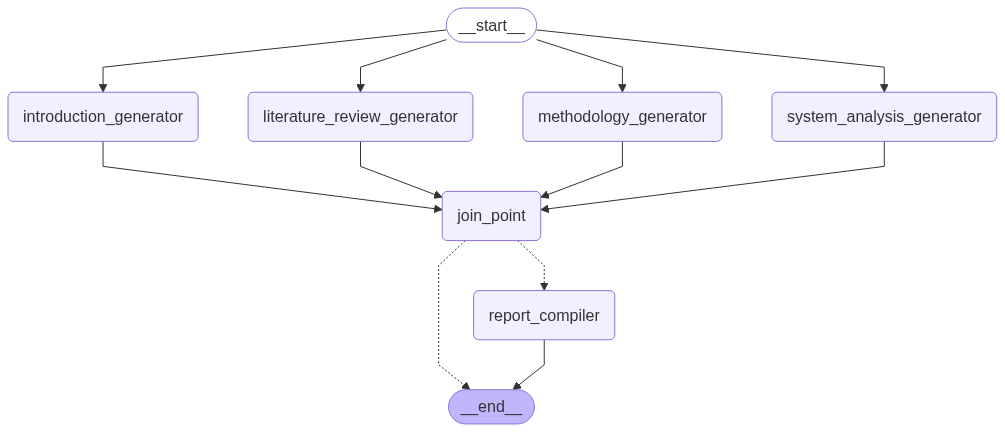

In [69]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END # Import START

# --- Define the "join" condition and routing logic ---
def all_sections_written(state):
    required_sections = ["introduction", "literature_review", "methodology", "system_analysis"]
    return all(state.get(section) is not None for section in required_sections)

def route_to_compiler_or_wait(state):
    if all_sections_written(state):
        print("\n--- All sections ready, proceeding to compiler ---")
        return "report_compiler"
    else:
        print("\n--- Not all sections ready, path ending to wait ---")
        return "__end__" # Special LangGraph key to end this path

# Initialize the graph
workflow = StateGraph(ReportState)

# Add asynchronous writer nodes
workflow.add_node("introduction_generator", intro_writer_node_async)
workflow.add_node("literature_review_generator", literature_review_node_async)
workflow.add_node("methodology_generator", methodology_node_async)
workflow.add_node("system_analysis_generator", system_analysis_node_async)

# Add a dummy node for the join point (doesn't modify state)
workflow.add_node("join_point", lambda state: state)

# Add the asynchronous compiler node
workflow.add_node("report_compiler", compile_report_node_async)


# --- Define graph edges for Parallel Execution ---

# 1. Fan out from START to all parallel writer nodes
workflow.add_edge(START, "introduction_generator")
workflow.add_edge(START, "literature_review_generator")
workflow.add_edge(START, "methodology_generator")
workflow.add_edge(START, "system_analysis_generator")

# 2. All writer nodes lead to the "join_point"
workflow.add_edge("introduction_generator", "join_point")
workflow.add_edge("literature_review_generator", "join_point")
workflow.add_edge("methodology_generator", "join_point")
workflow.add_edge("system_analysis_generator", "join_point")

# 3. Conditional routing from the "join_point"
# This is where the graph waits for all incoming edges to be traversed
workflow.add_conditional_edges(
    "join_point",
    route_to_compiler_or_wait,
    {
        "report_compiler": "report_compiler", # If ready, go to compiler
        "__end__": END  # If not all sections are ready, this path ends.
                        # LangGraph engine waits for all START-initiated branches
                        # before *actually* transitioning from join_point to compiler.
    }
)

# 4. Compiler leads to the final END
workflow.add_edge("report_compiler", END)

# Compile the graph
app_parallel = workflow.compile()


# Display the graph structure (shows the parallel branches converging)
try:
    img_data = app_parallel.get_graph().draw_mermaid_png()
    if img_data:
        display(Image(img_data))
except Exception:
    pass # Suppress errors for conciseness

In [ ]:

initial_input = {
    "original_query": "Federated learning in computer vision (pneumnonia detection)",
    "messages": [HumanMessage(content="Start report generation with Gemini.")]
}
print("Running parallel async graph using app_parallel.ainvoke()...")

# This MUST be awaited in a Jupyter cell
final_state_parallel = await app_parallel.ainvoke(initial_input, {"recursion_limit": 30}) # Increased limit for parallel

print("\n--- Parallel Graph Execution Finished (ainvoke) ---")

# Access final state results
print("\nFinal Compiled Report (from parallel ainvoke):")
if final_state_parallel and final_state_parallel.get('compiled_report'):
    print(final_state_parallel['compiled_report'][:500] + "...")

print("\nFinal Message Log (from parallel ainvoke):")
if final_state_parallel and 'messages' in final_state_parallel and isinstance(final_state_parallel['messages'], list):
    for i, msg in enumerate(final_state_parallel['messages']):
        print(f"{i+1}. {msg.type}: {str(msg.content)[:100]}...")
else:
    print("Messages not found.")

Running parallel async graph using app_parallel.ainvoke()...
--- ASYNC WRITING INTRODUCTION (GEMINI) ---
--- ASYNC WRITING LITERATURE REVIEW (GEMINI) ---
--- ASYNC WRITING METHODOLOGY (GEMINI) ---
--- ASYNC WRITING SYSTEM ANALYSIS (GEMINI) ---


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...
Here's an introduction for your report on federated learning in computer vision for pneumonia detection:

**Introduction**

Pneumonia, a significant global health concern, necessitates rapid and accurate diagnosis for effective treatment. Traditional methods often rely on centralized medical image analysis, which raises critical privacy concerns regarding sensitive patient data. Furthermore, the need for large, labeled datasets for training robust computer vision models presents a challenge, particularly in resource-constrained settings where data acquisition and annotation can be difficul

In [71]:
print("\nFinal Compiled Report (from parallel ainvoke):")
if final_state_parallel and final_state_parallel.get('compiled_report'):
    print(final_state_parallel['compiled_report'][:50000] + "...")

print("\nFinal Message Log (from parallel ainvoke):")
if final_state_parallel and 'messages' in final_state_parallel and isinstance(final_state_parallel['messages'], list):
    for i, msg in enumerate(final_state_parallel['messages']):
        print(f"{i+1}. {msg.type}: {str(msg.content)[:50000]}...")
else:
    print("Messages not found.")


Final Compiled Report (from parallel ainvoke):
## Introduction

Pneumonia, a significant global health concern, necessitates rapid and accurate diagnosis for effective treatment. Traditional methods often rely on centralized medical image analysis, which raises critical privacy concerns regarding sensitive patient data. Furthermore, the need for large, labeled datasets for training robust computer vision models presents a challenge, particularly in resource-constrained settings where data acquisition and annotation can be difficult and expensive.

This report explores the application of federated learning (FL) as a promising solution to these challenges in the context of pneumonia detection using computer vision. FL enables the collaborative training of machine learning models across decentralized datasets, without directly sharing the raw patient data. This approach preserves patient privacy while leveraging the collective knowledge of multiple institutions or hospitals. The importan